# The Computational Image of the City: Landmarks - Light-Mode
Four scores are here computed to extract computation landmarks: structural, visual, pragmatic.
Currently, the user has to provide the building shapefile, collected independently. The height is the only necessary field, plus two datasets containing respectively information about cultural/historical landmarks (e.g. position of listed important buildings) and land-use.

In [136]:
import osmnx as ox, matplotlib.cm as cm, pandas as pd, numpy as np, geopandas as gpd
import matplotlib.pyplot as plt
from importlib import reload
import functools
%matplotlib inline

import landmarks_functions as lf
import utilities as uf
import plotting as pf

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

In [141]:
reload(lf)

<module 'landmarks_functions' from 'C:\\Users\\g_filo01\\sciebo\\scripts\\Image of the City\\landmarks_functions.py'>

## Obtaining the Data
#### Fill the list 'places' with the names of the cities of interest. Buildings footprints are dowloaded for each city from OpenStreetMap within a certain distance from the centre of each city. The distance is set by the user. Each geodataframe is projected automatically (check OSMNx documentation for more information). The geodataframes are then cleaned and only relevant columns are kept. 

In [120]:
distance_from_center = 1000
places = ['London, UK', 'Torino, Italy', 'Berlin, Germany', 'Beograd, Serbia', 'New York, US', 'Beirut, Lebanon']

In [155]:
buildings_gdfs = []
to_keep = ['amenity', 'building', 'geometry', 'height', 'historic','building:height', 'land_use']

for city in places:

    tmp = ox.footprints.footprints_from_address(address= city, distance = distance_from_center, footprint_type = 'building', 
                                                                retain_invalid = False)
    tmp_proj = ox.projection.project_gdf(tmp)
    
    tmp_proj['land_use'] = None
    for column in tmp_proj.columns: 
        if column.startswith('building:use:'): tmp_proj.loc[pd.notnull(tmp_proj[column]), 'land_use'] = column[13:]
        if column not in to_keep: tmp_proj.drop(column, axis = 1, inplace = True)
            
    tmp_proj = tmp_proj[~tmp_proj['geometry'].is_empty]
    tmp_proj['building'].replace('yes', np.nan, inplace = True)
    tmp_proj['building'][tmp_proj['building'].isnull()] = tmp_proj['amenity']
    tmp_proj['land_use'][tmp_proj['land_use'].isnull()] = tmp_proj['building']
    tmp_proj['land_use'][tmp_proj['land_use'].isnull()] = 'residential'
    
    if 'historic' in tmp_proj.columns:
        tmp_proj['historic'][tmp_proj['historic'].isnull()] = 0
        tmp_proj['historic'][tmp_proj['historic'] != 0] = 1
        # cultural score - simple boolean version:
        tmp_proj['cult'] = tmp_proj['historic']
    else: tmp_proj['cult'] = 0.0
    
#   tmp_proj['height'][tmp_proj['height'].isnull()] = tmp_proj['building:height']
    tmp_proj = tmp_proj[['geometry', 'cult', 'land_use']]
    tmp_proj['area'] = tmp_proj.geometry.area
    
    # reset index
    tmp_proj = tmp_proj.reset_index(drop = True)
    tmp_proj['buildingID'] = tmp_proj.index.values.astype('int64')
    
    buildings_gdfs.append(tmp_proj)

## Visualisation

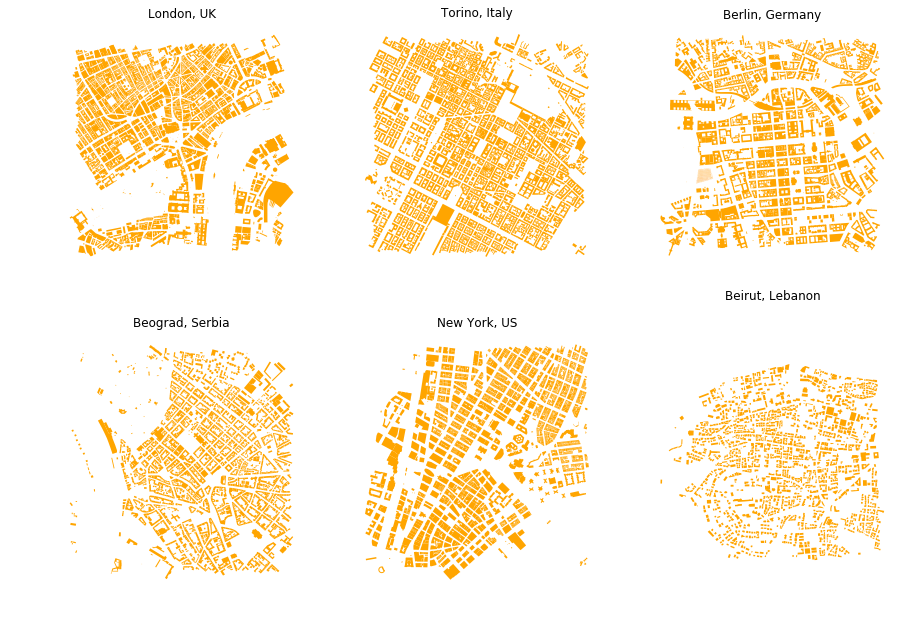

In [128]:
pf.multi_plot_polygons(buildings_gdfs, list_sub_titles = places, main_title = "Buildings' footprints" bb = False)

## 1 - Structural component

In [ ]:
"""
computes:
- distance from the road
- number of adjacent buildings 
- area (already computed in the previous step)

"""
sn = []
for n, city in enumerate(places):
    # reading the street network
    G = ox.graph_from_address(city, network_type = "all", distance = distance_from_center)
    streets_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
    ox.projection.project_gdf(streets_gdf)
    sn.append(streets_gdf)

In [156]:
for n, city in enumerate(places):
    tmp = buildings_gdfs[n]
    # The 'buffer' parameter indicates distance within the algorithms look for neighbouring buildings
    buildings_gdfs[n] = lf.structural_properties(tmp, tmp, sn[n], buffer = 150)

London, UK
Torino, Italy
Berlin, Germany
Beograd, Serbia
New York, US
Beirut, Lebanon


## 2 - Visual component

In [ ]:
# Not computed at the moment as in most of the cases height information is not provided in OSM

## 3 - Cultural component
#### It has been computed above

## 4 - Pragmatic component

Here different land-use datasets are loaded to assign land-use categorisation to the *buildings* GDF. At the moment this part is city-dependent. The pragmatic score is computed on the large area (*obstructions* GDF) to take into account adjacent buildings also along the edge of the case-study area. The method here used to assign land-use descriptors to the main GDF is based on geometries intersection. From polygons GDFs: Tha land-use of the building *x* in the external GDF is assigned to the building *y* from the *buildings* GDF, only when the intersection area cover 60% of *y*. From points GDFs: simple intersection.

In [157]:
"""
The 'buffer' parameter indicates the extension of the area that is used to compute the score of a building, on the basis of
its land-use's frequency, in an area of 'buffer' meters around it.
"""
for n, city in enumerate(places):
    tmp = lf.classify_lu(buildings_gdfs[n], 'land_use') #check function for classification methodology
    buildings_gdfs[n] = lf.pragmatic_meaning(tmp, buffer = 200)

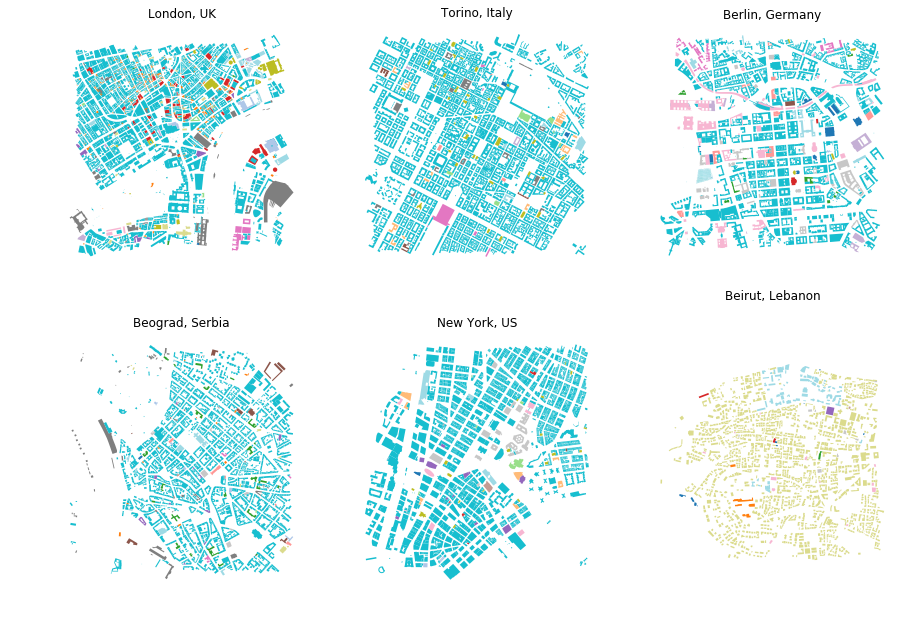

In [158]:
# visualising land use categorisation
pf.multi_plot_polygons(buildings_gdfs, list_sub_titles = places, main_title = "Land Use Distribution", 
                       column = 'land_use', cmap = 'tab20', bb = False)

# 5 - Final scores

### Weights definition.
#### Weights of components and indexes that are not computed due to data availability are set to 0

In [159]:
# global landmarkness components weights
g_cW = {'vScore': 0.00, 'sScore' : 0.60, 'cScore': 0.10, 'pScore': 0.30}
# global landmarkness indexes weights, cScore and pScore have only 1 index each
g_iW = {'vis': 0.00, 'fac': 0.00, 'height': 0.00, 'area': 0.50, 'a_vis': 0.00, 'neigh': 0.30 , 'road': 0.20}

# global landmarkness components weights
l_cW = {'vScore': 0.05, 'sScore' : 0.65, 'cScore':0.10 , 'pScore': 0.30}
# global landmarkness indexes weights, cScore and pScore have only 1 index each
l_iW = {'vis': 0.00, 'fac': 0.00, 'height': 0.00, 'area': 0.50, 'a_vis': 0.00, 'neigh': 0.30 , 'road': 0.20}

In [195]:
# Global and Local Score (1500 mt area)
reload(lf)
for n, city in enumerate(places):
    buildings_gdfs[n] = lf.compute_scores(buildings_gdfs[n], g_cW, g_iW)
    # buildings = lf.local_scores(buildings, l_cW, l_iW, 1500)

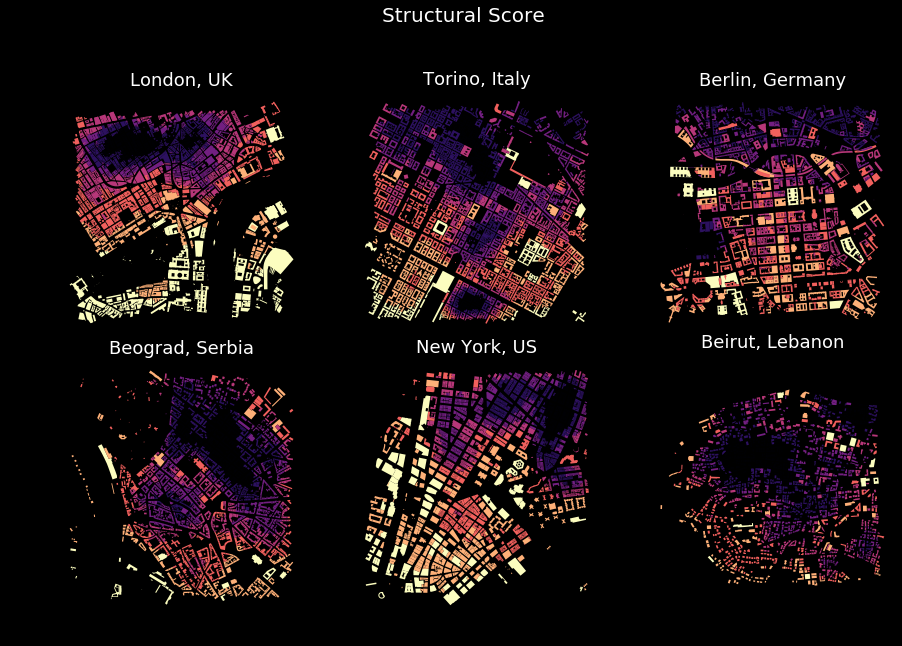

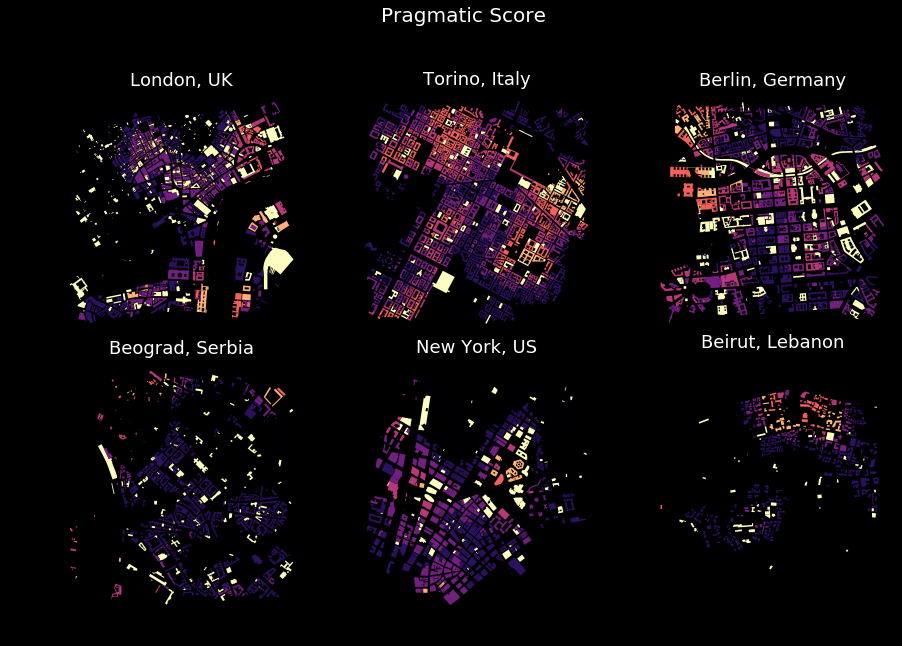

In [233]:
# visualising the four componets' maps, the color bar can be activated adding: cb = True
reload(pf)
pf.multi_plot_polygons(buildings_gdfs, list_sub_titles = places, main_title = "Structural Score",  
                       classes = 7, column = 'sScore_sc', cmap = 'magma', scheme = 'fisher_jenks')

In [236]:
places[2]

'Berlin, Germany'

In [239]:
buildings_gdfs[2]['gScore_sc'].mean()

0.12214872515189477

In [ ]:
pf.multi_plot_polygons(buildings_gdfs, list_sub_titles = places, main_title = "Pragmatic Score", 
                       classes = 7, column = 'pScore', cmap = 'magma', scheme = 'fisher_jenks')

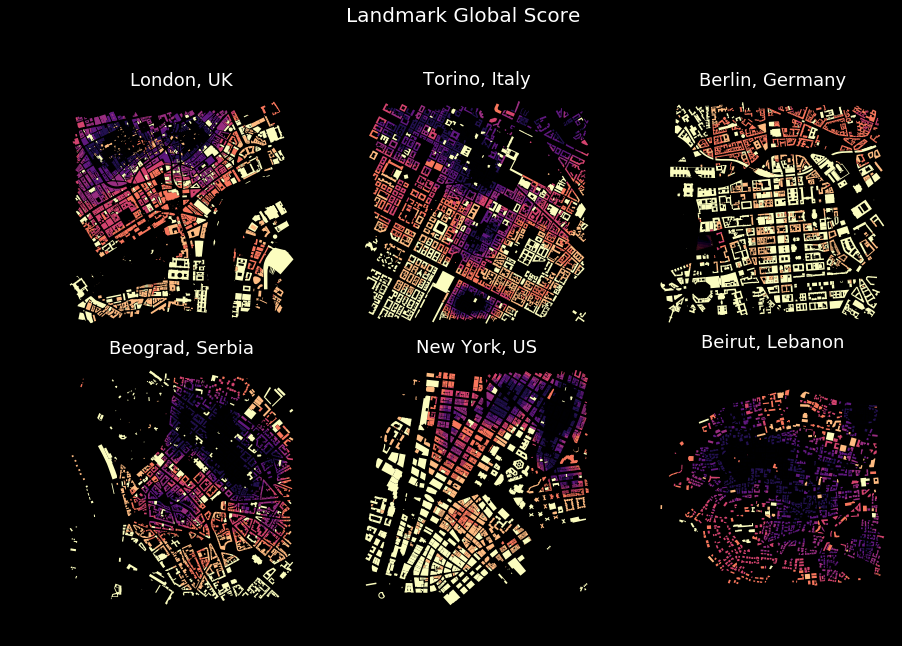

In [234]:
pf.multi_plot_polygons(buildings_gdfs, list_sub_titles = places, main_title = "Landmark Global Score",  
                       classes = 8, column = 'gScore_sc', cmap = 'magma', scheme = 'fisher_jenks')

In [58]:
buildings.to_file('Outputs/'+city_name+'/intermediate/'+city_name+'_landmarks_noADV.shp', driver='ESRI Shapefile')